In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy.stats
import geopandas as gpd
%matplotlib inline
from IPython.display import Markdown
from functools import reduce
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go

In [2]:
dataframe = pd.read_csv("data/RV_O_010_L_OK_SK.CSV", sep=';')
dataframe.head()
display(dataframe['abs.'].sum())

5449270

In [3]:
url = "https://bbrejova.github.io/viz/data/districts.json"
districts = gpd.read_file(url)
display(districts.head())
display(districts.info())

,LAU1,DOW,IDN3,NM3,IDN2,NM2,NUTS2,NUTS2_CODE,NUTS3,NUTS3_CODE,LAU1_CODE,LAU2,LAU2_CODE,geometry
0,Banská Bystrica,2021-02-26 00:00:00+00:00,601,Banská Bystrica,6,Banskobystrický,Stredné Slovensko,SK03,Banskobystrický kraj,SK032,SK0321,Badín,SK0321508454,"POLYGON ((-408449.300 -1239367.000, -408777.00..."
1,Banská Štiavnica,2021-02-26 00:00:00+00:00,602,Banská Štiavnica,6,Banskobystrický,Stredné Slovensko,SK03,Banskobystrický kraj,SK032,SK0322,Svätý Anton,SK0322516597,"POLYGON ((-440822.840 -1272799.420, -440809.15..."
2,Bardejov,2021-02-26 00:00:00+00:00,701,Bardejov,7,Prešovský,Východné Slovensko,SK04,Prešovský kraj,SK041,SK0411,Abrahámovce,SK0411519014,"POLYGON ((-251311.230 -1194615.930, -251463.13..."
3,Bratislava I,2021-02-26 00:00:00+00:00,101,Bratislava I,1,Bratislavský,Bratislavský kraj,SK01,Bratislavský kraj,SK010,SK0101,Bratislava-Staré Mesto,SK0101528595,"POLYGON ((-575659.050 -1277509.490, -575929.03..."
4,Bratislava II,2021-02-26 00:00:00+00:00,102,Bratislava II,1,Bratislavský,Bratislavský kraj,SK01,Bratislavský kraj,SK010,SK0102,Bratislava-Ružinov,SK0102529320,"POLYGON ((-564128.190 -1281777.370, -563932.30..."


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   LAU1        79 non-null     object             
 1   DOW         79 non-null     datetime64[ns, UTC]
 2   IDN3        79 non-null     int64              
 3   NM3         79 non-null     object             
 4   IDN2        79 non-null     int64              
 5   NM2         79 non-null     object             
 6   NUTS2       79 non-null     object             
 7   NUTS2_CODE  79 non-null     object             
 8   NUTS3       79 non-null     object             
 9   NUTS3_CODE  79 non-null     object             
 10  LAU1_CODE   79 non-null     object             
 11  LAU2        79 non-null     object             
 12  LAU2_CODE   79 non-null     object             
 13  geometry    79 non-null     geometry           
dtypes: datetime64[ns, UTC](1), geometry(

None

In [4]:
merged = pd.merge(districts, dataframe, right_on='Kód okresu', left_on='LAU1_CODE')
display(len(merged['LAU1_CODE'].unique()))
display(merged.info())
merged['abs.'].sum()

79

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   LAU1                       7017 non-null   object             
 1   DOW                        7017 non-null   datetime64[ns, UTC]
 2   IDN3                       7017 non-null   int64              
 3   NM3                        7017 non-null   object             
 4   IDN2                       7017 non-null   int64              
 5   NM2                        7017 non-null   object             
 6   NUTS2                      7017 non-null   object             
 7   NUTS2_CODE                 7017 non-null   object             
 8   NUTS3                      7017 non-null   object             
 9   NUTS3_CODE                 7017 non-null   object             
 10  LAU1_CODE                  7017 non-null   object             
 

None

5449270

<Axes: title={'center': 'Percent of people with 3. degree'}>

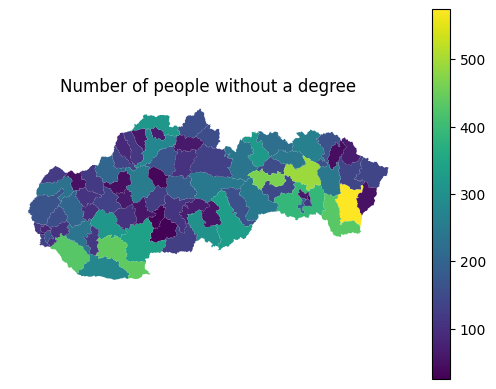

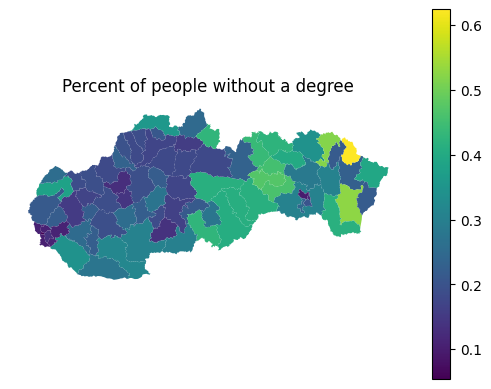

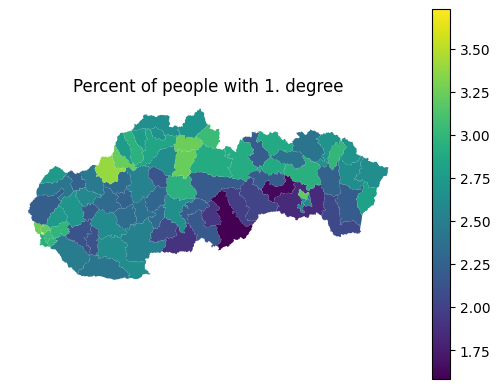

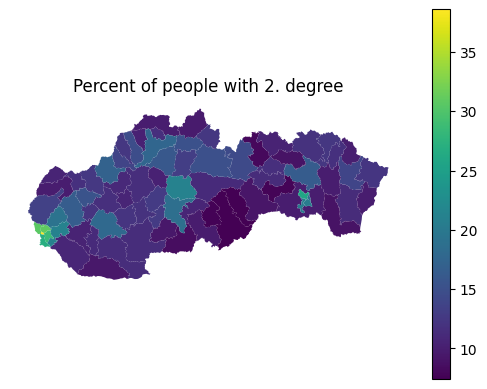

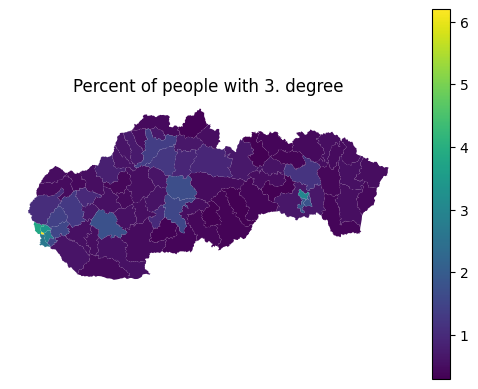

In [6]:
def with_selected_edu(dataframe: pd.DataFrame, geo_unit: str, selected_edu: list[str], title, kind: ('count', 'percent')='percent'):
    series_list = [dataframe['Vzdelanie'] == edu for edu in selected_edu]
    selected_edu = reduce(lambda x, y: x | y, series_list, pd.Series(False, index=dataframe['Vzdelanie'].index))
    selected = dataframe[selected_edu]
    edu_count = selected.groupby(geo_unit)['abs.'].sum().rename('count')
    edu_unit = edu_count.reset_index()
    if kind == 'count':
        to_merge = edu_unit
    elif kind == 'percent':
        population_count = dataframe.groupby(geo_unit)['abs.'].sum().rename('population')
        population_unit = population_count.reset_index()
        to_merge = pd.merge(population_unit, edu_unit, on=geo_unit)
        to_merge['percent'] = 100 * to_merge['count'] / to_merge['population']
    else:
        raise Exception("Given kind is not supported")
    geo = districts.set_index(geo_unit)
    # merged = districts.merge(to_merge, on=geo_unit)
    to_merge.set_index(geo_unit, inplace=True)
    geo[kind] = to_merge[kind]
    fig = geo.plot(column=kind, legend=True)
    plt.title(title)
    plt.axis('off')
    # plt.show()
    return fig

edu_types = merged['Vzdelanie'].unique()
high_edu = edu_types[14:22]
without_edu = [edu_types[-1]]
with_selected_edu(merged, 'LAU1_CODE', without_edu, kind='count', title='Number of people without a degree')
with_selected_edu(merged, 'LAU1_CODE', without_edu, kind='percent', title='Percent of people without a degree')
with_selected_edu(merged, 'LAU1_CODE', edu_types[19:20], kind='percent', title='Percent of people with 1. degree')
with_selected_edu(merged, 'LAU1_CODE', edu_types[20:21], kind='percent', title='Percent of people with 2. degree')
with_selected_edu(merged, 'LAU1_CODE', edu_types[21:22], kind='percent', title='Percent of people with 3. degree')

In [ ]:
%%script true # Skip
app = Dash(__name__)

app.layout = html.Div([
    html.H4("Select style for the plot: "),
    dcc.Checklist(
        id='selected_edu',
        options=[{'label': v, 'value': i} for i, v in enumerate(edu_types)],
        value=[0]
    ),
    dcc.Graph(id='geo-map'),
])

@app.callback(
    Output('geo-map', 'figure'),
    [Input('selected_edu', 'value')]
)
def update_figure(selected_edu):
    figure = with_selected_edu(merged, 'NUTS3_CODE', selected_edu)

    return figure

app.run_server(mode='inline', port=8051)

In [ ]:
table_47 = pd.read_csv('data/RV_O_047_L_OK_SK.CSV', sep=';')
table_47.replace(['nezistené', 'dôverné'], np.NaN, inplace=True)
display(table_47.head())
print(*table_47['Zamestnanie (ISCO - triedy)'].unique(), sep='\n', file=open('out', 'w'))
display(len(table_47['Zamestnanie (ISCO - triedy)'].unique()))

,Kód okresu,Názov okresu,Pohlavie,5-ročné vekové skupiny,Vzdelanie,Zamestnanie (ISCO - triedy),abs.
0,SK0101,Okres Bratislava I,muž,15 - 19 rokov,NaN,NaN,1
1,SK0101,Okres Bratislava I,muž,15 - 19 rokov,základné vzdelanie (bližšie neuvedené),NaN,1
2,SK0101,Okres Bratislava I,muž,15 - 19 rokov,základné vzdelanie - 1. stupeň základnej školy,Pracovníci v osobných službách,1
3,SK0101,Okres Bratislava I,muž,15 - 19 rokov,základné vzdelanie - 2. stupeň základnej školy,"Odborní pracovníci v oblasti práva, sociálnych...",1
4,SK0101,Okres Bratislava I,muž,15 - 19 rokov,základné vzdelanie - 2. stupeň základnej školy,Administratívni pracovníci v zákazníckych služ...,1


44

In [ ]:
jobs_division = {
    'Pracovníci v osobných službách': 5,
    'Odborní pracovníci v oblasti práva, sociálnych vecí a kultúry a podobní pracovníci': 2,
    'Administratívni pracovníci v zákazníckych službách': 4,
    'Riadiaci pracovníci (manažéri) vo výrobe a v špecializovaných službách': 1,
    'Špecialisti v oblasti práva, sociálnych vecí a kultúry': 2,
    'Administratívni pracovníci na záznam číselných a skladových údajov': 4,
    'Predavači': 5,
    'Pracovníci pri likvidácii odpadu a ostatní nekvalifikovaní pracovníci': 9,
    'Riadiaci pracovníci (manažéri) v hotelových, reštauračných, obchodných a v ostatných službách': 1,
    'Špecialisti v oblasti vedy a techniky': 2,
    'Špecialisti v oblasti informačných a komunikačných technológií': 2,
    'Kvalifikovaní robotníci v hutníctve, strojárstve a podobní robotníci': 8,
    'Montážni robotníci': 8,
    'Vodiči a obsluha pojazdných strojných zariadení': 8,
    'Technici v oblasti informačných a komunikačných technológií': 3,
    'Elektrikári a elektronici': 7,
    'Riadiaci pracovníci (manažéri)  administratívnych, podporných a obchodných  činností': 1,
    'Špecialisti administratívnych, podporných a obchodných činností': 2,
    'Technici a odborní pracovníci v oblasti vedy a techniky': 3,
    'Odborní pracovníci v zdravotníctve': 2,
    'Odborní pracovníci administratívnych, podporných a obchodných činností': 2,
    'Pracovníci v oblasti osobnej starostlivosti': 5,
    'Spracovatelia a výrobcovia potravinárskych výrobkov, výrobkov z dreva a odevov': 7,
    'Operátori stacionárnych strojov a zariadení': 8,
    'Všeobecní administratívni pracovníci a zapisovatelia': 4,
    'Pracovníci verejnej ochrany a bezpečnostných služieb': 5,
    'Učitelia a odborní pedagogickí pracovníci': 2,
    'Ostatní pomocní administratívni pracovníci': 4,
    'Špecialisti v zdravotníctve': 2,
    'Pomocní pracovníci v ťažbe, stavebníctve, výrobe a doprave': 9,
    'Pomocní pracovníci pri príprave jedla': 9,
    'Kvalifikovaní pracovníci v poľnohospodárstve (trhovo orientovaní)': 6,
    'Zákonodarcovia, ústavní činitelia, vysokí štátni úradníci a najvyšší predstavitelia podnikov a organizácií': 1,
    'Umeleckí a ruční remeselníci a tlačiari': 7,
    'Ostatné ozbrojené sily': 0,
    'Dôstojníci ozbrojených síl': 0,
    'Upratovači a pomocníci': 9,
    'Kvalifikovaní stavební robotníci a remeselníci okrem elektrikárov': 7,
    'Pomocní pracovníci v poľnohospodárstve, lesníctve a rybárstve': 9,
    'Poddôstojníci ozbrojených síl': 0,
    'Pouliční predavači a pomocní pracovníci v podobných  službách': 5,
    'Kvalifikovaní pracovníci v lesníctve, rybárstve a poľovníctve (trhovo orientovaní)': 6,
    'Farmári, rybári, poľovníci a zberači úrody (samozásobovatelia)': 6
}
group_names = [
    "Armed forces",
    "Legislators, senior officials and managers",
    "Professionals",
    "Technicians and associate professionals",
    "Clerks",
    "Service workers and shop and market sales workers",
    "Skilled agricultural and fishery workers",
    "Craft and related trades workers",
    "Plant and machine operators and assemblers",
    "Elementary occupations",
]
table_47['Trieda'] = table_47['Zamestnanie (ISCO - triedy)'].map(jobs_division).map(dict(enumerate(group_names)))
table_47

,Kód okresu,Názov okresu,Pohlavie,5-ročné vekové skupiny,Vzdelanie,Zamestnanie (ISCO - triedy),abs.,Trieda
0,SK0101,Okres Bratislava I,muž,15 - 19 rokov,NaN,NaN,1,NaN
1,SK0101,Okres Bratislava I,muž,15 - 19 rokov,základné vzdelanie (bližšie neuvedené),NaN,1,NaN
2,SK0101,Okres Bratislava I,muž,15 - 19 rokov,základné vzdelanie - 1. stupeň základnej školy,Pracovníci v osobných službách,1,Service workers and shop and market sales workers
3,SK0101,Okres Bratislava I,muž,15 - 19 rokov,základné vzdelanie - 2. stupeň základnej školy,"Odborní pracovníci v oblasti práva, sociálnych...",1,Professionals
4,SK0101,Okres Bratislava I,muž,15 - 19 rokov,základné vzdelanie - 2. stupeň základnej školy,Administratívni pracovníci v zákazníckych služ...,1,Clerks
...,...,...,...,...,...,...,...,...
346459,SK042B,Okres Trebišov,žena,80 - 84 rokov,vyššie odborné vzdelanie nadstavbové (maturita...,NaN,1,NaN
346460,SK042B,Okres Trebišov,žena,80 - 84 rokov,vyššie odborné vzdelanie pomaturitné (pomaturi...,NaN,1,NaN
346461,SK042B,Okres Trebišov,žena,80 - 84 rokov,vyššie odborné vzdelanie pomaturitné (pomaturi...,Odborní pracovníci v zdravotníctve,1,Professionals
346462,SK042B,Okres Trebišov,žena,85 - 89 rokov,základné vzdelanie - 2. stupeň základnej školy,NaN,1,NaN


In [ ]:
geo_47 = pd.merge(districts, table_47, right_on='Kód okresu', left_on='LAU1_CODE')
geo_47.head()

,LAU1,DOW,IDN3,NM3,IDN2,NM2,NUTS2,NUTS2_CODE,NUTS3,NUTS3_CODE,...,LAU2_CODE,geometry,Kód okresu,Názov okresu,Pohlavie,5-ročné vekové skupiny,Vzdelanie,Zamestnanie (ISCO - triedy),abs.,Trieda
0,Banská Bystrica,2021-02-26 00:00:00+00:00,601,Banská Bystrica,6,Banskobystrický,Stredné Slovensko,SK03,Banskobystrický kraj,SK032,...,SK0321508454,"POLYGON ((-408449.300 -1239367.000, -408777.00...",SK0321,Okres Banská Bystrica,muž,15 - 19 rokov,NaN,NaN,3,NaN
1,Banská Bystrica,2021-02-26 00:00:00+00:00,601,Banská Bystrica,6,Banskobystrický,Stredné Slovensko,SK03,Banskobystrický kraj,SK032,...,SK0321508454,"POLYGON ((-408449.300 -1239367.000, -408777.00...",SK0321,Okres Banská Bystrica,muž,15 - 19 rokov,NaN,Administratívni pracovníci na záznam číselných...,1,Clerks
2,Banská Bystrica,2021-02-26 00:00:00+00:00,601,Banská Bystrica,6,Banskobystrický,Stredné Slovensko,SK03,Banskobystrický kraj,SK032,...,SK0321508454,"POLYGON ((-408449.300 -1239367.000, -408777.00...",SK0321,Okres Banská Bystrica,muž,15 - 19 rokov,základné vzdelanie - 1. stupeň základnej školy,NaN,1,NaN
3,Banská Bystrica,2021-02-26 00:00:00+00:00,601,Banská Bystrica,6,Banskobystrický,Stredné Slovensko,SK03,Banskobystrický kraj,SK032,...,SK0321508454,"POLYGON ((-408449.300 -1239367.000, -408777.00...",SK0321,Okres Banská Bystrica,muž,15 - 19 rokov,základné vzdelanie - 1. stupeň základnej školy,"Pomocní pracovníci v ťažbe, stavebníctve, výro...",1,Elementary occupations
4,Banská Bystrica,2021-02-26 00:00:00+00:00,601,Banská Bystrica,6,Banskobystrický,Stredné Slovensko,SK03,Banskobystrický kraj,SK032,...,SK0321508454,"POLYGON ((-408449.300 -1239367.000, -408777.00...",SK0321,Okres Banská Bystrica,muž,15 - 19 rokov,základné vzdelanie - 2. stupeň základnej školy,NaN,3,NaN


/tmp/ipykernel_7538/2467653503.py:26: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/tmp/ipykernel_7538/2467653503.py:26: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/tmp/ipykernel_7538/2467653503.py:26: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



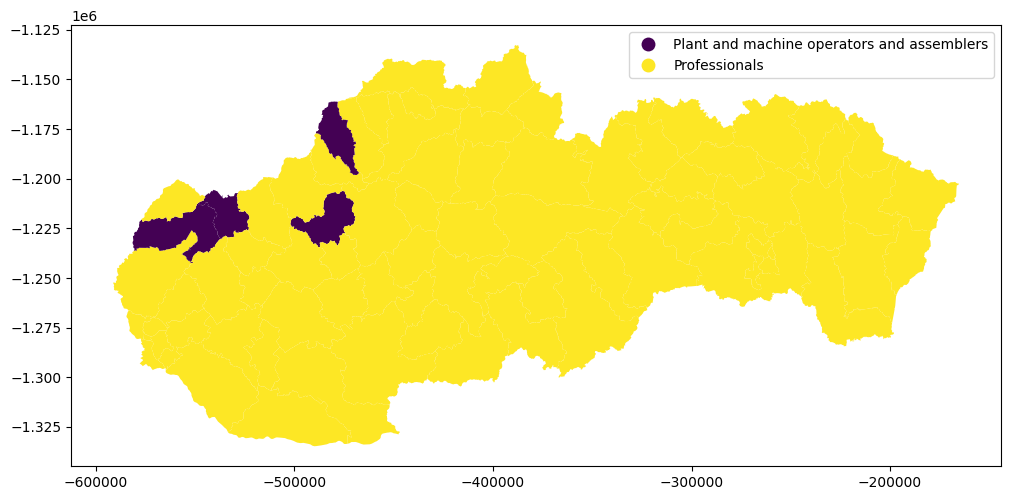

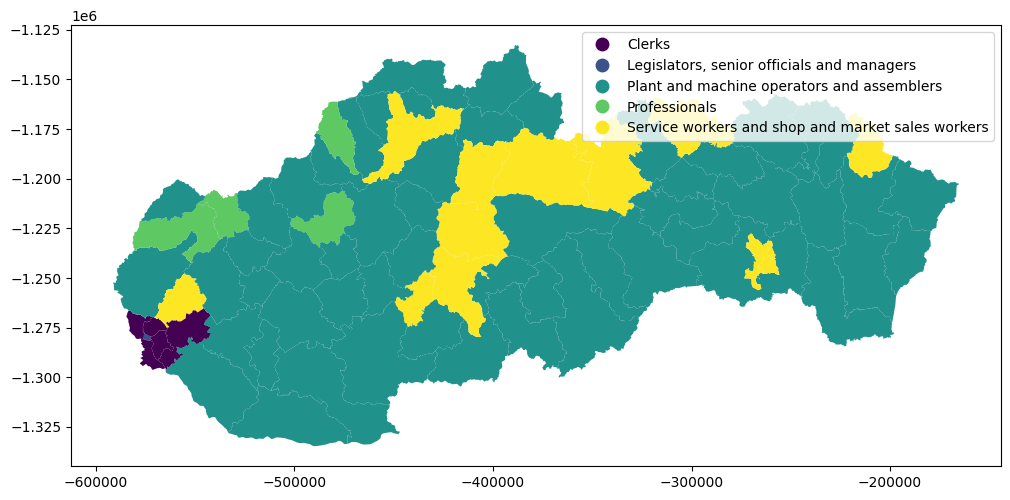

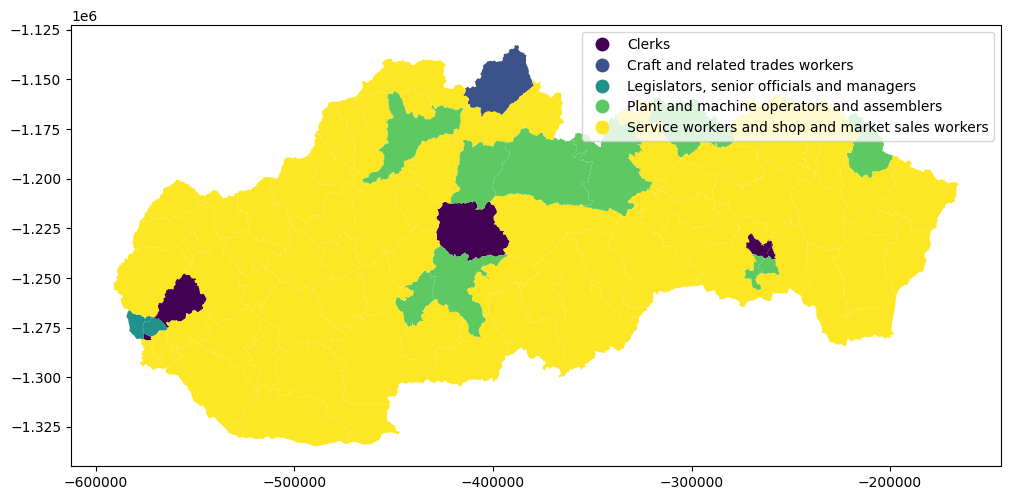

In [ ]:
def dominant_group(dataframe: pd.DataFrame, geo_unit: str, level=0):
    group_count = (
        dataframe.groupby([geo_unit, "Trieda"])["abs."].sum().rename("count").to_frame()
    )
    # dominant = group_count.groupby(level=geo_unit)['count'].idxmax()
    # dominant = group_count.loc[dominant].reset_index()
    dominant = group_count.sort_values([geo_unit, "count"], ascending=[True, False])
    dominant = dominant.groupby(level=geo_unit).nth(level).reset_index().set_index(geo_unit)
    geo = districts.set_index(geo_unit)
    geo['Trieda'] = dominant['Trieda']
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    geo.plot(column='Trieda', legend=True, ax=ax, cmap='viridis')
    # fig = go.Figure(go.Choroplethmapbox(
    #     geojson=geo.__geo_interface__,
    #     locations=geo.index,
    #     z=geo['Trieda'],  # Data to be visualized
    #     colorscale='Viridis',  # Color scale
    #     marker_opacity=0.5,
    #     marker_line_width=0.2
    # ))
    # fig = px.choropleth(
    #     geo_merged,
    #     locations=geo_merged.index,
    #     color=geo_merged.index,
    # )
    # fig.show()
    plt.axis('off')
    plt.show()


dominant_group(geo_47, "LAU1_CODE", level=0)
dominant_group(geo_47, "LAU1_CODE", level=1)
dominant_group(geo_47, "LAU1_CODE", level=2)